# STEAM EVALUATION
Author: Álvaro Javier Díaz Laureano 1639484

Aquest és un projecte corresponent a la assignatura de Aprenentatge Computacional a la UAB. La base de dades ha sigut extreta de Kaggle i el podem trobar com [Steam Store Games](https://www.kaggle.com/datasets/nikdavis/steam-store-games/data). El meu treball consisteix en realitzar una predicció del percentatge de positives ratings respecte el overall.

Importació de llibreries útils pel projecte.

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler

from sklearn.metrics import accuracy_score,  precision_score, recall_score, roc_curve, roc_auc_score, auc, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_curve, classification_report, average_precision_score

from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.model_selection import StratifiedKFold, train_test_split

from scipy.stats import spearmanr, pointbiserialr

import warnings
warnings.filterwarnings("ignore")

## Exploratory Data Analysis

Començare amb una exploració de les dades del meu dataset.

In [2]:
steam_data = pd.read_csv("steam.csv")
print(steam_data.shape)

(27075, 18)


In [3]:
print(steam_data.columns.values)

['appid' 'name' 'release_date' 'english' 'developer' 'publisher'
 'platforms' 'required_age' 'categories' 'genres' 'steamspy_tags'
 'achievements' 'positive_ratings' 'negative_ratings' 'average_playtime'
 'median_playtime' 'owners' 'price']


In [4]:
steam_data.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


Una primera visió del dataset ens indica que tenim 18 columnes amb 27075 files que corresponen a jocs de Steam al fitxer de steam.csv. També, a partir d'aquesta impressió de dades podem classificar el tipus de dades que trobem, que poden ser o categòriques o numèriques.
- Categòriques: name, release_date, english, developer, publisher, platforms, categories, genres, steamspy_tags, owners.
- Númeriques: appid, required_age, achievements, positive_ratings, negative_ratings, average_playtime, median_playtime, price.

Una petita descripció dels aspectes més importants abans de seguir és que trobem diverses columnes com Categories, Genres, Steamspy_tags o Platforms que estan en forma de llista. També trobem un valor en format de rangs als owners  i finalment una columna binaria, en aquest cas English, que indica si el joc esta en angles o no.

Veiem si alguna d'aquestes columnes porta NaNs.

In [5]:
print(f"Quantitat de NaNs al dataset: {steam_data.isna().sum().sum()}")

Quantitat de NaNs al dataset: 15


Com veiem, no tenim dades nules al nostre dataset pel que no cal fer cap fill ni tractament.

Podem veure que al nostre dataset ens falta afegir el que volem predir. Abans de realitzar la visualització de les nostres dades, crearé aquesta columna que ens permetra veure les correlacions entre atributs més endavant. Serà el percentatge de ratings positius respecte tots els ratings. També hauré de crear una columna que m'indiqui quina quantitat de ratings té cada joc.

In [6]:
steam_data["rating_game"] = steam_data["positive_ratings"] / (steam_data["positive_ratings"] + steam_data["negative_ratings"])
steam_data["num_ratings"] = steam_data["positive_ratings"] + steam_data["negative_ratings"]

Fem un petit analisis del nostre target. Com veiem el representem en forma de percentatge on el 100% es 1.0 i el 0% es 0.0. No es cap classificació binària i hi han molts valors diferents. Els models que utilitzaré es basaran en regressió.

Aquest és el historiograma del meu target i de la columna num_ratings creada.

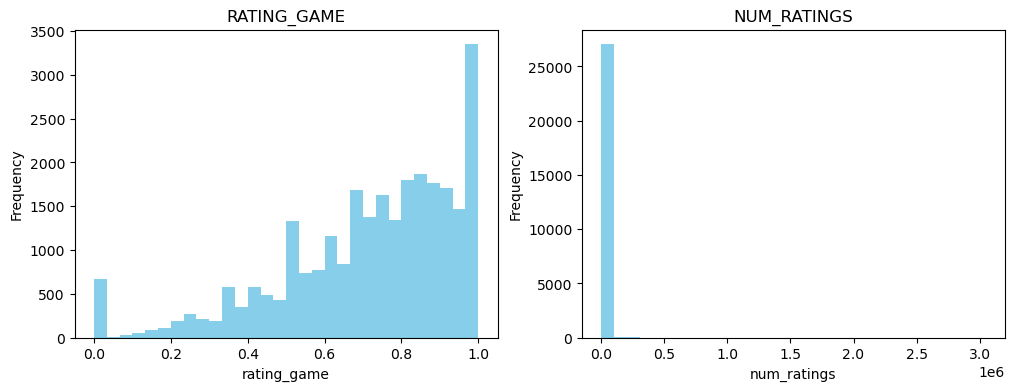

In [7]:
cols = ['rating_game', 'num_ratings']
fig, axes = plt.subplots(nrows=1, ncols=len(cols), figsize=(12, 4))

for i,col in enumerate(cols):
    axes[i].hist(steam_data[col], bins=30, color=['skyblue'])
    axes[i].set_title(col.upper())
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

Com podem veure esta bastant sesgat cap a la dreta. També podem veure que hi han dos pics molt elevats tan al valor 0 com al 1. Això pot ser degut a que hi han jocs que ni tan sols tenen un rating o unicament ratings negatius (valor 0) o jocs que tenen ratings únicament positius (valor 1). Per als dos casos considerem que el nombre de ratings total no és molt elevat.

Per altra banda, observem que la gràfica de num_ratings té un gran pic als valors propers a cero. Veiem aquesta desproporció degut a outliers.

Fem un analisi del que he comentat abans sobre els ratings a 0.0 i a 1.0.

In [8]:
ratings_zero = steam_data[steam_data['rating_game'] == 0.0]
ratings_one = steam_data[steam_data['rating_game'] == 1.0]

max_negative_index = ratings_zero['negative_ratings'].idxmax()
max_positive_index = ratings_one['positive_ratings'].idxmax()

max_negative_row = steam_data.loc[max_negative_index]
max_positive_row = steam_data.loc[max_positive_index]

max_rows = steam_data.loc[[max_negative_index, max_positive_index]]
max_rows

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,rating_game,num_ratings
24760,943880,Looking_for_food,2018-09-27,0,Xue yang,Xue yang,windows,0,Single-player,RPG,RPG;RPGMaker,0,0,22,0,0,0-20000,13.99,0.0,22
25913,992740,祈風 Inorikaze,2019-02-13,0,Twilight -日月之境-;觀象草圖 Astrolabe Draft,觀象草圖 Astrolabe Draft,windows,0,Single-player;Steam Achievements;Steam Cloud,Adventure;Casual;Indie,Adventure;Indie;Casual,20,114,0,75,75,0-20000,8.29,1.0,114


Com podem veure, he extret dels valors rating_game 0 i 1, els que tenen més ratings negatius i positius, respectivament. El que podem comprovar es com per el cas de 0.0 la quantitat de ratings que té son 22 i pel cas positiu 114. Tot i que pel cas positiu pot ser una excepció aquest cas, la gran majoria no s'apropen als 10 ratings en total. Més endavant decidiré que fer amb aquests valors.

Ara si procediré a fer una visualització de les dades.

Abans de tot, cal recalcar certs aspectes com que la columna Name no la representaré pel de que tots els valors són únics. El mateix amb Appid y Steamspy_tags, apart de la seva ambiguetat. També recalco que les agrupacions que faig no necessariament han de tenir relació.

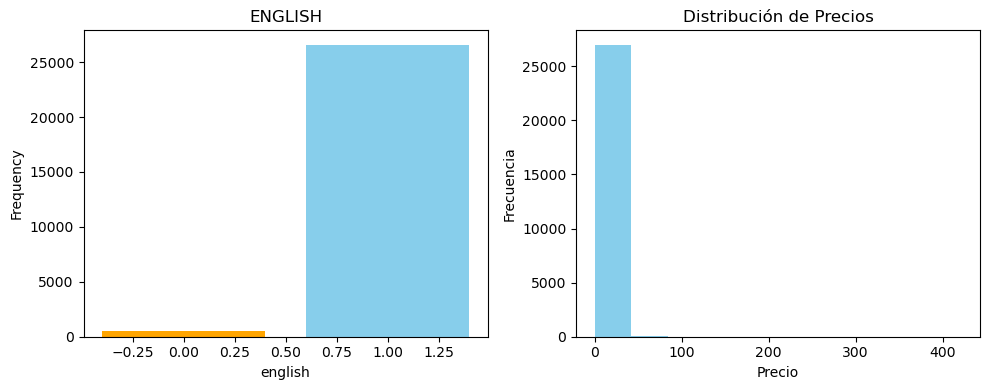

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

value_counts = steam_data['english'].value_counts()
axes[0].bar(value_counts.index, value_counts.values, color=['skyblue', 'orange'])
axes[0].set_title('ENGLISH')
axes[0].set_xlabel('english')
axes[0].set_ylabel('Frequency')

axes[1].hist(steam_data['price'], bins=10, color='skyblue')
axes[1].set_title('Distribución de Precios')
axes[1].set_xlabel('Precio')
axes[1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Comencem analitzant les columnes English i Price.

Totes dues columnes tenen un gran desbalceig. Bàsicament ens diuen que la majoria de jocs són en anglès i que no són gratis. A la columna English és més complicat trobar més dades de les que realment se'ns mostra. Price conté outliers que van fins a 400 euros de valor. La majoria de jocs, com és normal, es situen a preus no molt alts. Podem considerar aquells valors doncs outliers ja que s'ajunyen molt dels valors reals.


In [10]:
# Agregació de columna
is_free = steam_data['price'].apply(lambda x: 0 if x == 0.00 else 1)

He creat una nova columna per a partir de Price anomenada Is_free. Ens mostrarà els jocs que són gratis i els que no. Això bàsicament per simplicitat d'analisi de les dades. Més endavant faré l'analisi complet de la columna Price.

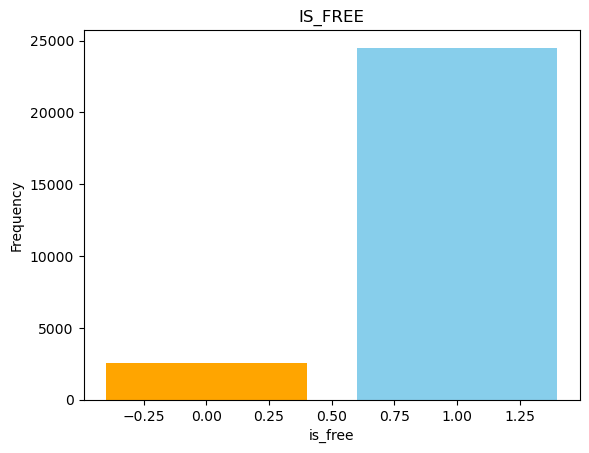

In [11]:
value_counts = is_free.value_counts()
plt.bar(value_counts.index, value_counts.values, color=['skyblue', 'orange'])
plt.title('IS_FREE')
plt.xlabel('is_free')
plt.ylabel('Frequency')
plt.show()

Hi ha un gran desbalanceig com ja hem vist abans a la columna original. Ens pot servir per fer el nostre model si ens aporta correlació.

Continuem amb la visualització.

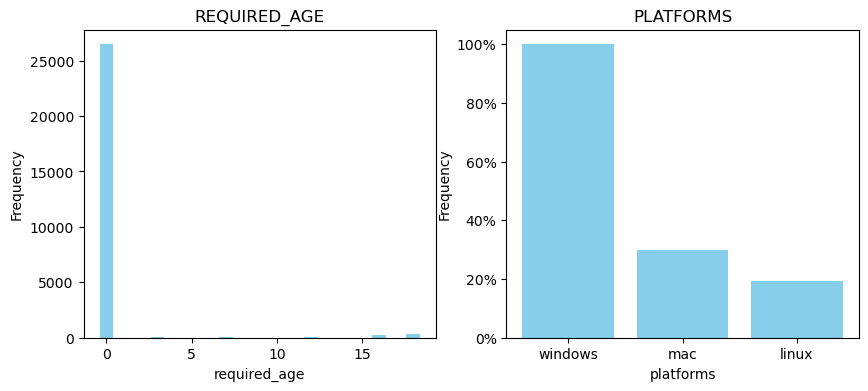

In [12]:
cols = ['required_age', 'platforms']
fig, axes = plt.subplots(nrows=1, ncols=len(cols), figsize=(10, 4))

for i,col in enumerate(cols):
    if col == 'platforms':
        value_counts = steam_data[col].str.split(';', expand=True).stack().value_counts() / len(steam_data)
        vals = plt.yticks()[0]
        plt.yticks(vals, ['{:,.0%}'.format(x) for x in vals])
    else:
        value_counts = steam_data[col].value_counts()
    axes[i].bar(value_counts.index, value_counts.values, color=['skyblue'])
    axes[i].set_title(col.upper())
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

Aquestes gràfiques corresponen amb Required_Age i Platforms. Required_Age té un desbalanceig important pel motiu de que gran part dels jocs no tenen una edat límit per ser jugats. No obstant, tot i que aquestes dades per si soles no ens donen molta informació, el que faré serà crear una nova columna que indiqui si el joc té limits d'edat.

Per altra banda, tenim Platforms que indica de cada joc les plataformes compatibles amb aquest. Podem observar que Windows té casi el 100% de compatibilitat amb el dataset sencer, seguit amb menys del 40% dels dispositius IOS i per últim Linux. Al tenir en consideració que com més compatible sigui un joc amb totes les plataformes, més fàcil és que arribi a tot el mon i, per tant, més útil evaluar-ho.

Veiem el gràfic de la nova columna creada a partir de Required_age.

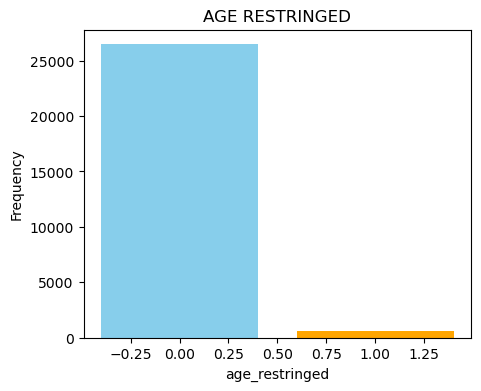

In [13]:
age_restringed = steam_data['required_age'].apply(lambda x: 0 if x == 0 else 1)


value_counts = age_restringed.value_counts()
plt.figure(figsize=(5, 4))
plt.bar(value_counts.index, value_counts.values, color=['skyblue', 'orange'])
plt.xlabel('age_restringed')
plt.ylabel('Frequency')
plt.title('AGE RESTRINGED')
plt.show()

Podem observar un gran desbalanceig, com ja es podia veure en la columna original. El principal motiu és el mateix que el d'abans.

Les següents columnes a visualitzar són developer i publisher.

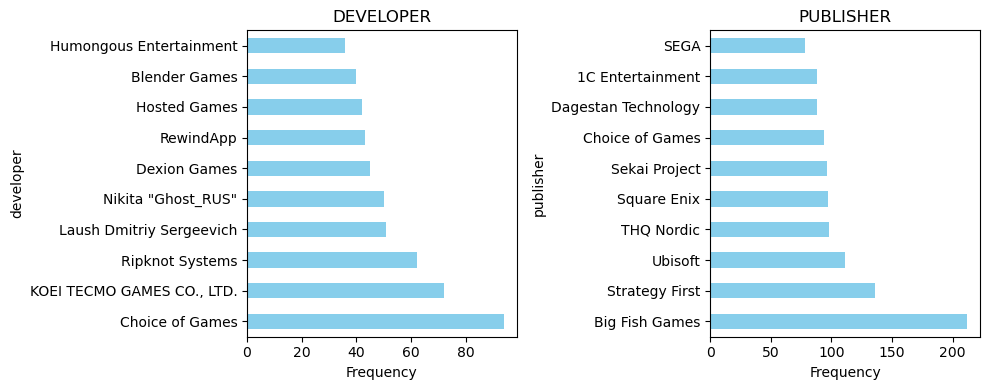

In [14]:
cols = ['developer', 'publisher']

fig, axes = plt.subplots(nrows=1, ncols=len(cols), figsize=(10, 4))
for col, ax in zip(cols, axes):
    aux = steam_data[col].value_counts().head(10)
    aux.plot(kind='barh', ax=ax, color='skyblue')
    ax.set_xlabel('Frequency')
    ax.set_ylabel(col)
    ax.set_title(col.upper())

plt.tight_layout()
plt.show()

Developer i Publisher són dues característiques molt importants alhora de determinar el rating d'un joc ja que es basa en prestigi, favoritisme i fanatisme. En aquestes dues gràfiques veiem únicament els 10 primers desarrolladors i editors que més apareixen al dataset. Aquest si pot ser un factor determinant alhora de determinar el rating d'un joc, no obstant, considero que al tenir un gran número de valors únics, preparar aquestes dades per entrenar un model pot ser un problema. Les consideraré si es cau més endavant.

La següent visualització es basa en dades numèriques.

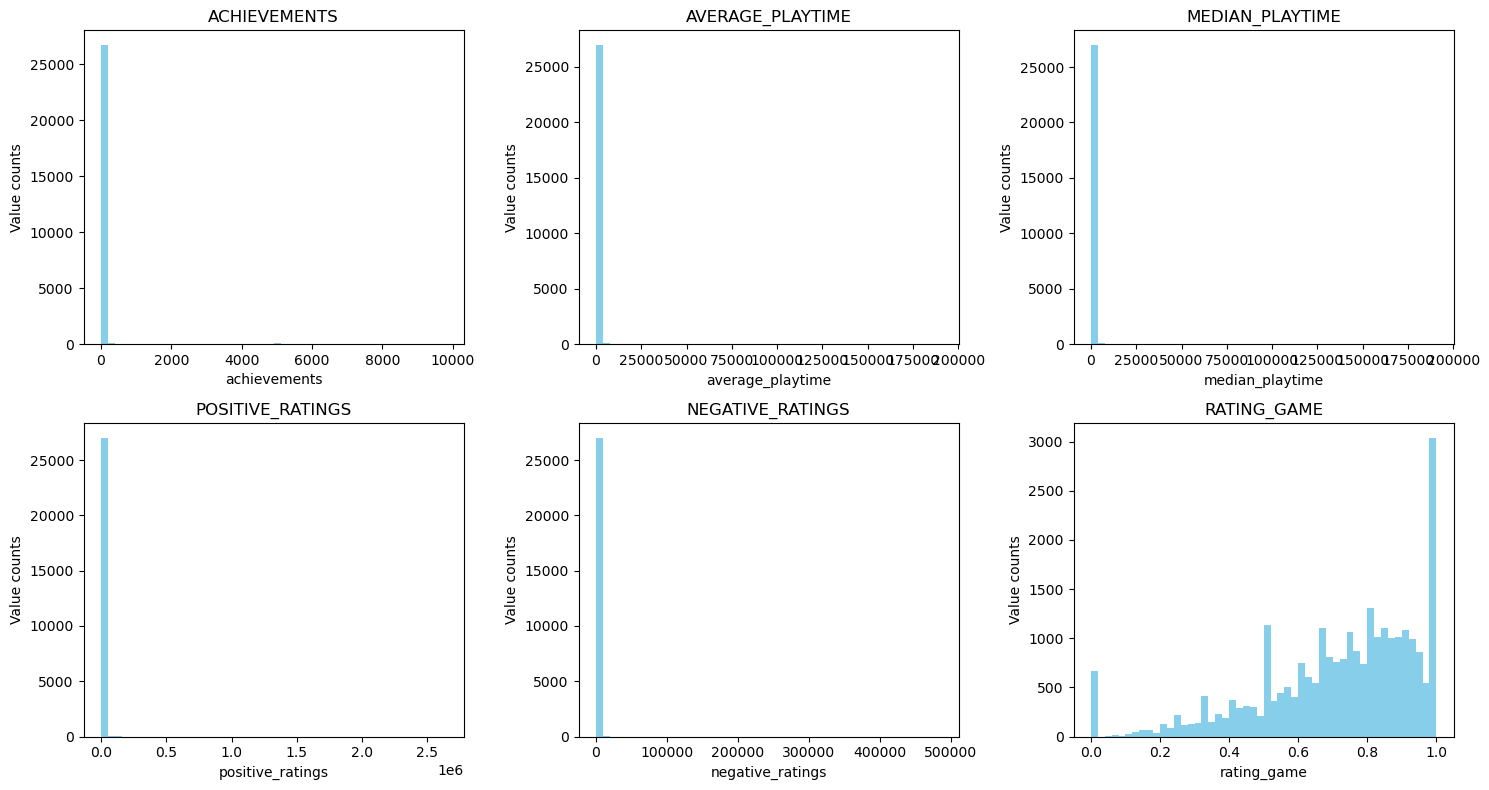

In [15]:
cols = ['achievements', 'average_playtime', 'median_playtime', 'positive_ratings', 'negative_ratings', 'rating_game']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

for col, ax in zip(cols, axes.flatten()):
    steam_data[col].plot(kind='hist', bins=50, ax=ax, color='skyblue')
    ax.set_ylabel('Value counts')
    ax.set_xlabel(col)
    ax.set_title(col.upper())

plt.tight_layout()
plt.show()

En aquesta figura podem observar 6 gràfiques. Totes amb desbalancejos a les quals hauriem d'aplicar un filtratge.

La columna Achievements ens diu que hi ha moltes mostres que tenen 0 achievements per aconseguir al joc. Podriem convertir aquesta columna en si el joc té achievements o no i, pot ser, ens donaria més informació que la quantitat que té cada cadascun apart de ser més visual.

Les columnes Average i Median Playtime i Positive i Negative Rating tenen un pic proper al valor 0. Com positive i negative ratings són dues columnes que formen Rating_Game no faré cap anàlisi més profund a difèrencia de Average i Median Playtime on s'ha d'aplicar un filtre o un tractament d'outliers que provoca aquest pic tan alt. No obstant, per facilitat, crearé noves columnes en base a aquestes que indiquin si un joc ha estat jugat o no.

Rating Game per altre joc ja l'hem vist abans. No obstant, aqui podem apreciar més bé els pics i com veiem, ens podem fixar com també trobem un pic al 50%. Aixó és degut a dades que contenen les mateixes dades per positive com negative ratings. Tindré aquest fet més endavant.

Fem una petita visualització de la nova columna creada a partir de average o median playtime i achievements.

In [16]:
game_played = steam_data['average_playtime'].apply(lambda x: 0 if x == 0 else 1)
has_achievements = steam_data['achievements'].apply(lambda x: 0 if x == 0 else 1)

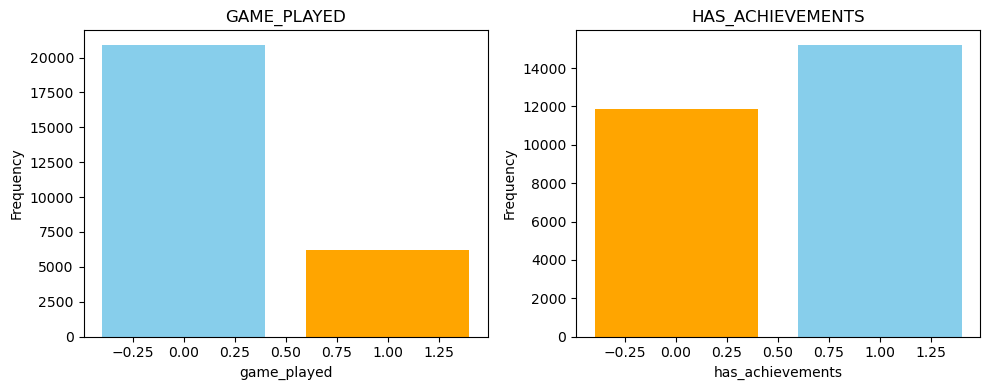

In [17]:
cols = [game_played, has_achievements]
names = ['game_played', 'has_achievements']
fig, axes = plt.subplots(nrows=1, ncols=len(cols), figsize=(10, 4))

for i,col in enumerate(cols):
    value_counts = col.value_counts()
    axes[i].bar(value_counts.index, value_counts.values, color=['skyblue', 'orange'])
    axes[i].set_title(names[i].upper())
    axes[i].set_xlabel(names[i])
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


Aquest diagrama de barres ens indica que la gran majoria de jocs del nostre dataset no ha sigut jugat. Es a dir, que té el temps a cero. Per altra banda, a la nova columna Has_achievements veiem que esta bastant balancejat i que, més o menys, tenim la mateixa quantitat de jocs que no tenen achievements i que si tenen.

A continuació veurem Release Date.

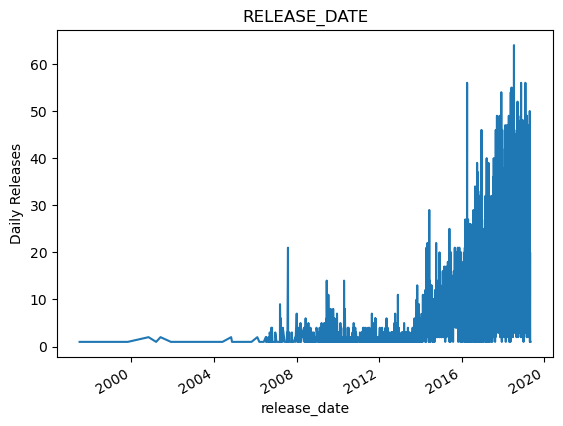

In [18]:
steam_data['release_date'] = steam_data['release_date'].astype('datetime64[ns]')
release_counts = steam_data['release_date'].value_counts().sort_index()
plt.figure()
release_counts.plot()
plt.ylabel('Daily Releases')
plt.title('RELEASE_DATE')
plt.show()

Release_Date indica les dates de sortida de cada joc. Podem veure que fins al 2006 més o menys no habian sortit molts jocs. Es a partir d'aquesta data que comencem a veure una gran sortida de jocs amb el pas dels anys, sobretot a partir del 2014 aproximadament.

Fem una visualització que només tingui en compte els anys.

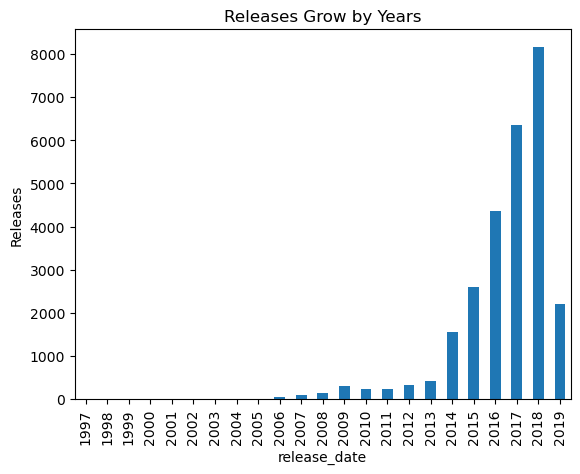

In [19]:
plt.figure()
steam_data['release_date'].dt.year.value_counts().sort_index().plot(kind = 'bar')
plt.ylabel('Releases')
plt.title('Releases Grow by Years')
plt.show()

Amb aquesta nova visualització podem extreure nova informació. Bàsicament veiem una gran depressió a l'any 2019. Això pot significar que son dades incomplertes i que al 2019 estan les dades que no acaben de figurar a la seva data correcta. Dificilment trobarem certa relació de la data de publicació amb el nostre target. No incluirem més aquesta columna en el nostre analisis.

Continuem amb Owners.

In [20]:
#renombrar clases para legibilidad
nuevos_nombres = {
    '100000000-200000000': '100M-200M',
    '50000000-100000000': '50M-100M',
    '20000000-50000000': '20M-50M',
    '10000000-20000000': '10M-20M',
    '5000000-10000000': '5M-10M',
    '2000000-5000000': '2M-5M',
    '1000000-2000000': '1K-2M',
    '500000-1000000' : '500K-1M',
    '200000-500000' : '200K-500K',
    '100000-200000' : '100K-200K',
    '50000-100000': '50K-100K',
    '20000-50000': '20K-50K',
    '0-20000' : '0-20K'
}

def transformar_valor(valor):
    rango_numerico = valor.split('-')
    inicio = int(rango_numerico[0])
    fin = int(rango_numerico[1])
    nuevo_nombre = nuevos_nombres.get(f"{inicio}-{fin}", f"{inicio}-{fin}")
    return nuevo_nombre

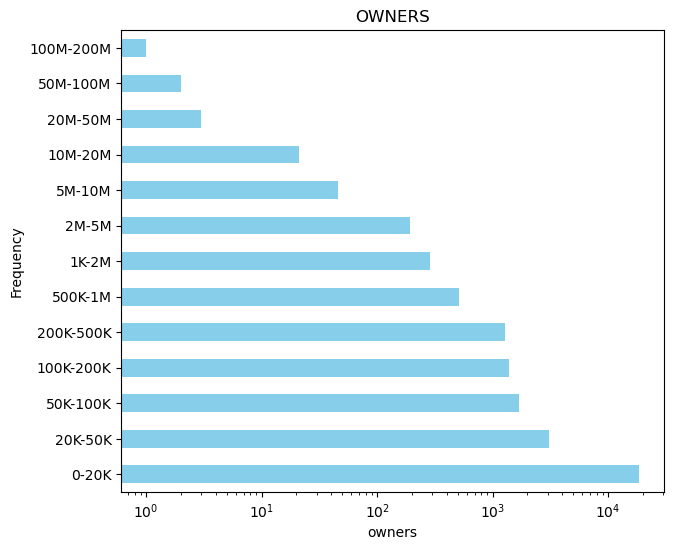

In [21]:
steam_data['owners'] = steam_data['owners'].apply(transformar_valor)

value_counts = steam_data['owners'].value_counts()
plt.figure(figsize=(7, 6))
value_counts.plot(kind='barh', color='skyblue')
plt.xlabel('owners')
plt.ylabel('Frequency')
plt.title('OWNERS')
plt.xscale('log')
plt.show()

Aquesta gràfica no mostra més res que la quantitat de gent que té el joc en qüestió. Podem observar com només una petita quantitat de jocs tenen entre 100 i 200 milions. La classe més freqüent de la columna és de 0 a 20 mil owners. Com ja he vist abans, hi han una gran quantitat de jocs que no han estat jugats, cosa que podem associar a que aquesta classe d'owners sigui tan abundant significant que molts dels jocs tenen 0 owners.

Les següents dues columnes són Categories i Genres.

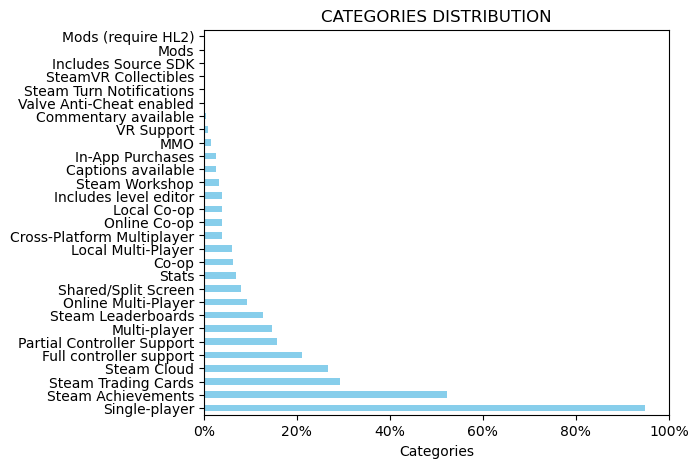

In [22]:
categories_split = steam_data['categories'].str.split(';')
all_categories = [category for categories in categories_split for category in categories]

plt.figure(figsize=(6, 5))
category_counts = pd.Series(all_categories).value_counts() / len(steam_data)
category_counts.plot(kind='barh', color='skyblue')
plt.xlabel('Categories')
plt.title('CATEGORIES DISTRIBUTION')
vals = plt.xticks()[0]
plt.xticks(vals, ['{:,.0%}'.format(x) for x in vals])
plt.show()

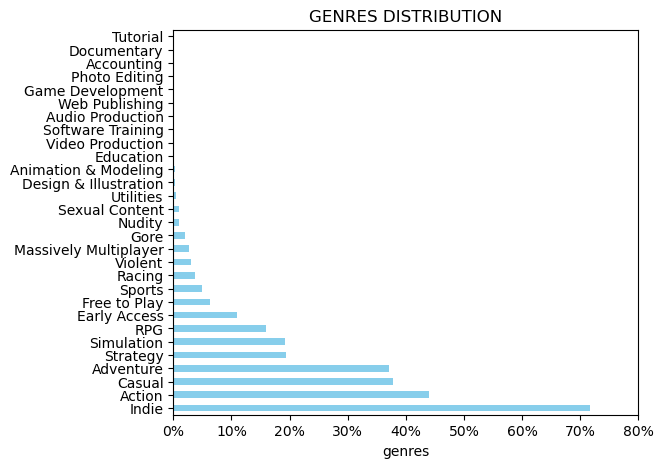

In [23]:
genres_split = steam_data['genres'].str.split(';')
all_genres = [genre for genres in genres_split for genre in genres]

plt.figure(figsize=(6, 5))
genres_counts = pd.Series(all_genres).value_counts() / len(steam_data)
genres_counts.plot(kind='barh', color='skyblue')
plt.xlabel('genres')
plt.title('GENRES DISTRIBUTION')
vals = plt.xticks()[0]
plt.xticks(vals, ['{:,.0%}'.format(x) for x in vals])
plt.show()

Per aquestes dues últimes columnes hem realitzat una separació de les dades dins de cada mostra i fer el recompte tenint en consideració que un joc pot tenir més d'un gènere o categoria. A priori no es veu cap cosa fora de lo normal. Tenim com a gènere famós el Indie i com a categoria freqüent Singl-Player.

Una vegada analitzat tots els atributs, el que volem és que fem un petit anàlisi de correlacions amb la columna que s'ha de predir. Com el nostre problema tracta de regressió, lo ideal primer seria fer un analisi de linietat. Això per veure les relacions entre les variables numèriques i el meu target, també numèric. Tot i així, posteriorment també faré un analisi a partir de la matriu de correlació.

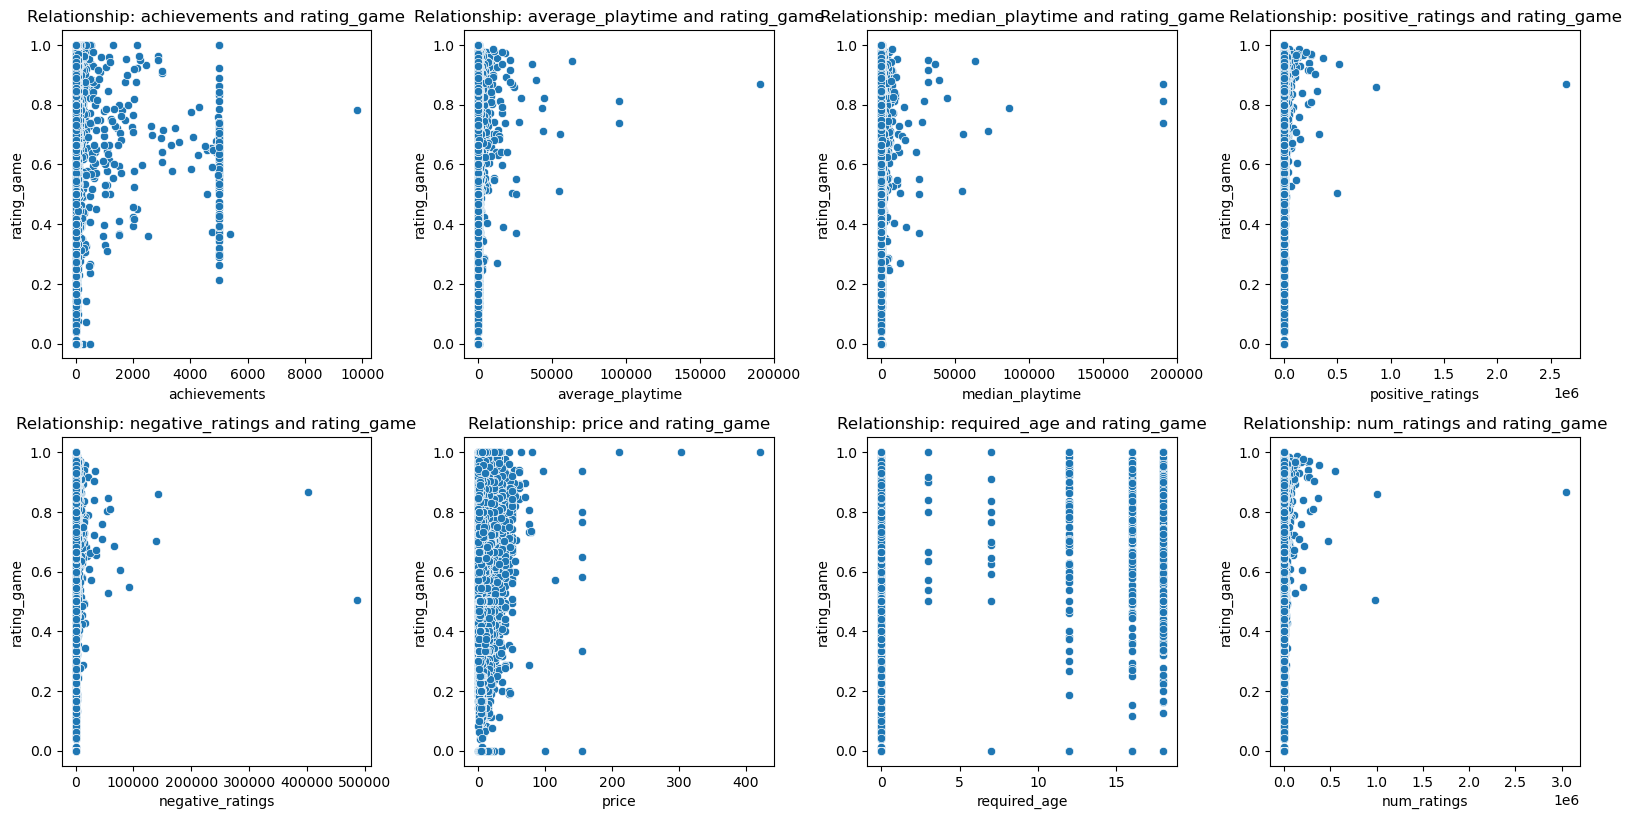

In [24]:
features = ['achievements', 'average_playtime', 'median_playtime', 'positive_ratings', 'negative_ratings', 'price', 'required_age', 'num_ratings']

n_rows = len(features) // 2 + len(features) % 2
n_cols = 4
plt.figure(figsize=(16, n_rows * 4))
for i, feature in enumerate(features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.scatterplot(data=steam_data, x=feature, y='rating_game')
    plt.title(f'Relationship: {feature} and rating_game')

plt.tight_layout()
plt.show()

Aquestes són les gràfiques scatterplot resultants de les variables numeriques del nostre dataset. A primera vista, podem veure com totes les gràfiques ens indiquen cero linietat entre les variables i el nostre target. Tractem doncs amb relacions no lineals.  

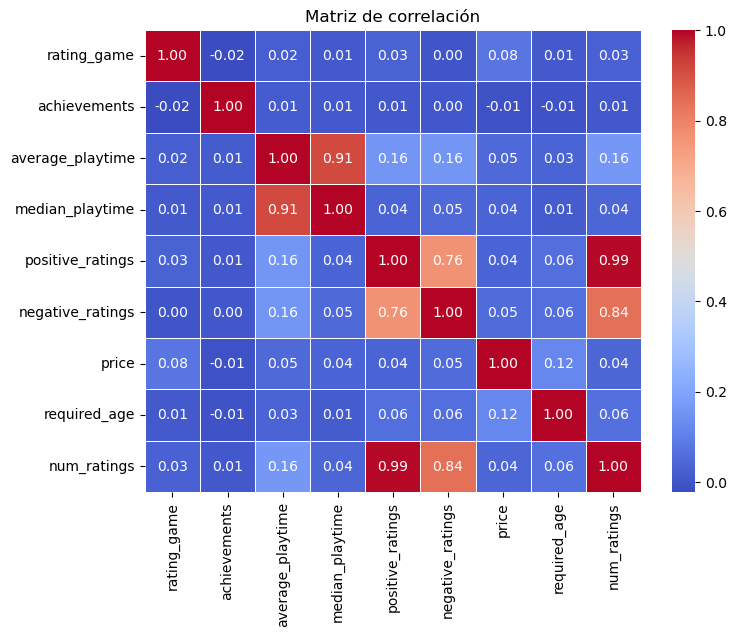

In [25]:
correlation_matrix = steam_data[['rating_game', 'achievements', 'average_playtime', 'median_playtime', 'positive_ratings', 'negative_ratings', 'price', 'required_age', 'num_ratings']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de correlación')
plt.show()

En aquesta matriu la fila més importants és la del nostre target. A primera vista podem veure que no hi ha cap relació important més que pel price que s'ajunya una mica més que la resta del 0. Això pot ser perquè la relació preu-qualitat és un factor important alhora de evaluar un joc. Pel que fa amb la resta, els altres atributs no semblen tenir cap relació directa amb el nostre target.

A part de rating_game, trobem altres relacions importants entre average_playtime i median_playime, positive_ratings i negative_ratings. Els dos primers poden estar relacionats per similitut de conceptes estadístics. Per altra banda, la relació amb els ratings pot ser degut a que quantes més hores jugades més valoracions trobarem o menys respectivament.

També veiem relació entre negative_ratings i positive_ratings, i aquests dos amb num_ratings, encara que no és sorpresa. Entre price i required_age també tot i que no és molt.


Com ja he analitzat les relaciones entre variables numeriques, ara pasaré a les variables categòriques. Únicament veure aquelles dades que crec més útils d'analitzar i sobretots aquelles que hem extret abans de les variables nùmeriques ja que veiem que originalment no hi ha indicis de relació entre aquestes i el target.

Comencem amb Owners que requereix una operació diferent a la resta al tenir diverses classes. Per evaluar la correlació d'aquesta utilitzaré la correlació de Spearman.

In [26]:
correlation, p_value = spearmanr(steam_data['owners'], steam_data['rating_game'])

print(f"Correlación de Spearman: {correlation}")
print(f"Valor p: {p_value}")

Correlación de Spearman: -0.009237331005607847
Valor p: 0.12853176722879986


Els resultats ens diuen que no sembla haver relació estadística significativa entre els owners i el rating game. No vol dir que no hi hagi relació, sino que és prou dèbil com per no detectar-la com significativa. Per tant, podriem obviar-la del nostre model.

Els següents atributs tenen en comu que són binaris i podem ficar els resultats de cadascun en una taula per per una millor observació.

Utilitzaré la correlació biserial puntual, útil quan volem mesurar la correlació entre dades binaries i el nostre target numèric. El valor p ens indicarà si es significativament estadístic el valor donat a la correlació. Si és menor al 0.05 podrem dir que té significancia.

In [27]:
english = steam_data['english']
names = ['game_played', 'is_free', 'english', 'has_achievements','age_restringed']
cols = [game_played, is_free, english, has_achievements,age_restringed]

resultados = []
for i,col in enumerate(cols):
  correlation, p_value = pointbiserialr(col, steam_data['rating_game'])
  resultados.append({'Variables': f'{names[i]} vs rating_game', 'Correlación': correlation, 'Valor p': p_value})

df_resultados = pd.DataFrame(resultados)
df_resultados

,Variables,Correlación,Valor p
0,game_played vs rating_game,0.055284,8.772795e-20
1,is_free vs rating_game,-0.006338,2.969940e-01
2,english vs rating_game,-0.017599,3.781317e-03
3,has_achievements vs rating_game,0.172329,1.654588e-179
4,age_restringed vs rating_game,0.008631,1.555451e-01


No faré un analisí individual per cadascun dels casos. El que faré serà una visió general dels resultats.

Podem veure directament els valors que superen el 0.05, que són les columnes is_free i age_restringed. Aquestes directament podem dir que no tenen cap correlació amb el nostre target, a més de tenir un valor bastant baix d'aquest.

Per altra banda, a game_played i english, tot i que la correlació és baixa, el valor p, que pels dos casos és molt baix, ens indica que son estadísticament significatius.

Per últim, la columna has_achievements té una correlació moderadament més elevada que la resta indicant que hi ha relació entre el target i els achievements. A més, el valor p és massa baix pel que indica una relació estadísitca molt significativa.

Com a conclusions, a partir d'aquest apartat, puc determinar les següents:
- Appid i Steamspy_tags proporcionen informació ambigua.
- Develeper, Publisher i Name tenen una gran quantitat de valors únics. Difícilment es pot fer un bon encoding.
- Price sembla tenir més correlació amb el target en la seva forma original que en la columna is_free on no hi ha relació.
- Achievements, Required_age, Average_playtime i Median_playtime no tenen correlació amb el nostre target. Les columna creada a partir d'achievements si que en té correlació i game_played mitjanament també. Age_restringed tampoc té correlació.
- Categories and Genres no tenen una gran quantitat de valors únics pels que es pot fer un enconding.
- Positive i Negative Rating es transformen a Rating_Game on està el percentatge exacte.
- Al nostre target podem trobar els valors bastants sesgats.

Tot i que aquestes són les conclusions de les dades, no podem dir quina importancia real tenen fins que fem un preprocessing i veiem altre cop quina és la distribució real i la que ens interessa.

## PREPROCESSING

A partir d'aquí, el que faré serà un preprocessament abans de realitzar l'avaluació de models. Tractaré els aspectes comentats en l'apartat anterior realitzant una serie de passos com: tractament d'outliers, filtre de certes columnes,encoding, normalització i escalat i un drop de les dades que no m'interessen.


El primer a fer serà el tractament del desbalanceig del nostre target. Donada la nostra situació de desbalanceig, el que no volem és obtenir un mal rendiment al nostre model d'aprenentatge. Així doncs, el primer aspecte a tenir en compte, serà l'extracció de outliers. Faré un primer analisi dels outliers. He de comentar, que per la naturalesa de les dades de num_ratings, no faré la extracció d'outliers pertinent. Bàsicament perquè no m'interessa perdre aquelles dades que tenen molts ratings ja que pot ser un factor decisiu alhora de predir bé un rating o no.

Dit això, fem l'analisi.

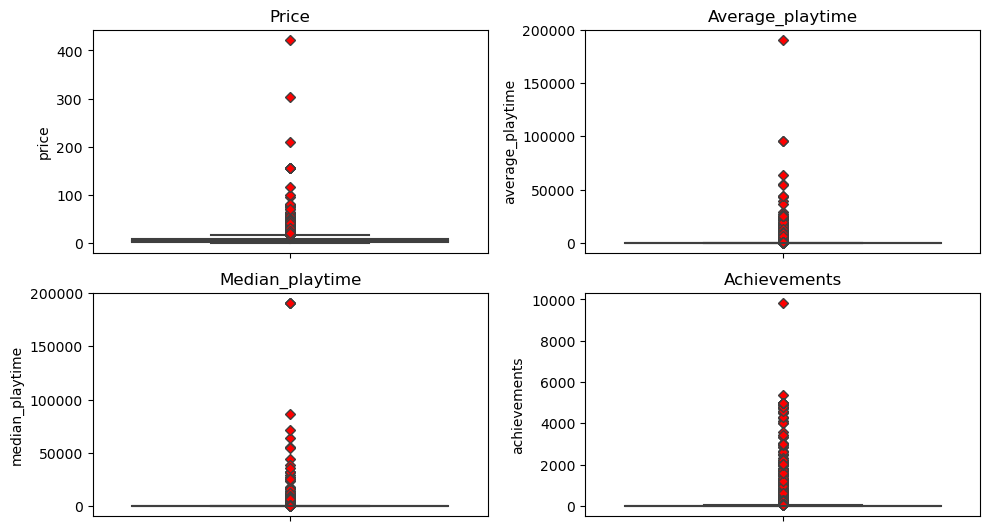

In [28]:
columns = ['price', 'average_playtime', 'median_playtime', 'achievements']
plt.figure(figsize=(10, 8))

for i, col in enumerate(columns, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(y=steam_data[col], flierprops=dict(markerfacecolor='r', marker='D'))
    plt.title(col.capitalize())

plt.tight_layout()
plt.show()

Podriem fer una extracció treient tots els punts que veieme vermells. El problema seria que treuriem massa dades i perderiem informació important.

In [29]:
def count_outliers(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return len(outliers)

def extract_outliers(df, col, threshold = 0):
    if threshold == 0:
      Q1 = df[col].quantile(0.25)
      Q3 = df[col].quantile(0.75)
      IQR = Q3 - Q1

      lower_bound = Q1 - 1.5 * IQR
      upper_bound = Q3 + 1.5 * IQR
      data_filtred = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    else:
      data_filtred = df[df[col] < threshold]

    return data_filtred


outlier_counts = {col: count_outliers(steam_data[col]) for col in columns}
outlier_counts

{'price': 1975,
 'average_playtime': 6170,
 'median_playtime': 6170,
 'achievements': 1695}

Veiem que per price i achievements no són una gran quantitat de dades pel que podriem fer l'extracció sense problemes.

Average_playtime i median_playtime és altre cas. Tenim massa dades que són outliers. El que faré aquí serà fer una extracció arbitraria.


In [30]:
threshold = 1000
valors_umbral1 = steam_data[steam_data['average_playtime'] > threshold]
valors_umbral2 = steam_data[steam_data['median_playtime'] > threshold]

(valors_umbral1.shape[0], valors_umbral2.shape[0])

(590, 537)

He establert un umbral a 1000 minuts jugats com valors atípics. Podem veure que pràcticament no suposen perdua. Farem l'extracció i veurem com queden les gràfiques.


In [31]:
steam_data = extract_outliers(steam_data, 'price')
steam_data = extract_outliers(steam_data, 'achievements')
steam_data = extract_outliers(steam_data, 'average_playtime', 1000)
steam_data = extract_outliers(steam_data, 'median_playtime', 1000)

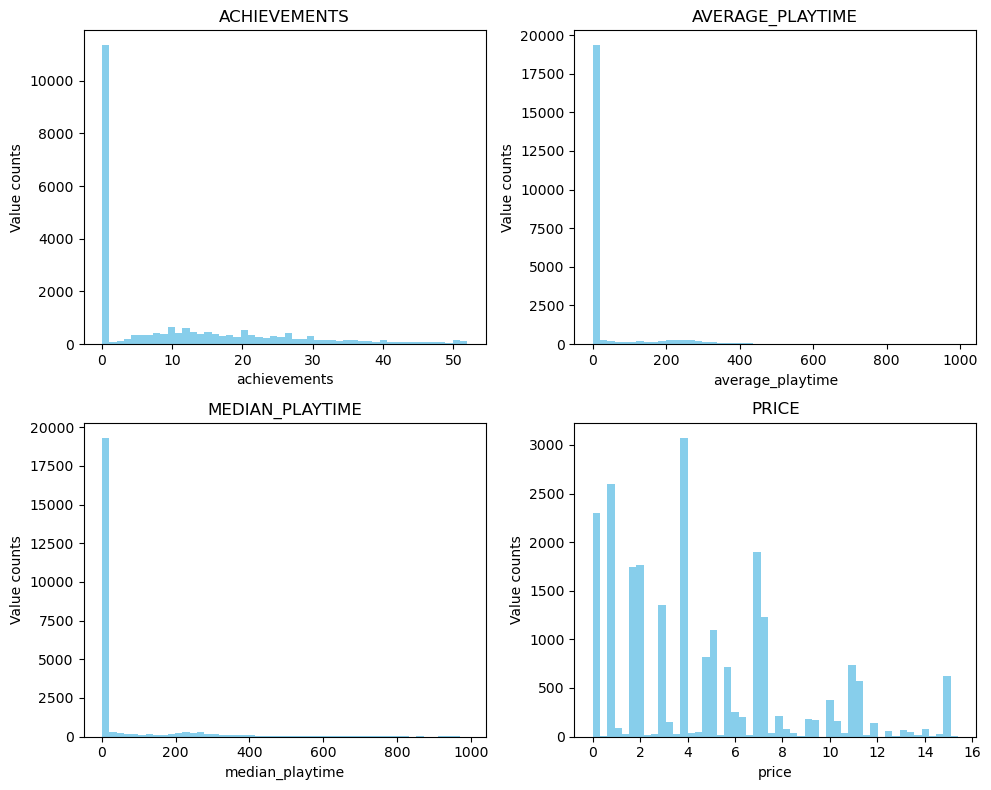

In [32]:
cols = ['achievements', 'average_playtime', 'median_playtime', 'price']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

for col, ax in zip(cols, axes.flatten()):
    steam_data[col].plot(kind='hist', bins=50, ax=ax, color='skyblue')
    ax.set_ylabel('Value counts')
    ax.set_xlabel(col)
    ax.set_title(col.upper())

plt.tight_layout()
plt.show()

Tot i que per average i median playtime segueixen quedant molts outliers, arà tenim una millor distribució en general fent fora aquells valors atípics.

Continuem amb rating_game. Com ja vaig dir, els valors de 0 i 1 de rating no m'interessaven pel fet de que poden donarnos una mala representació de les dades portant resultats erronis. Per tant, extrauré aquells valors que són 0 o 1. Sobretot perquè son dades condicionades ja sigui perquè no tenen resenyes o perquè únicament tenen 1 o 2 valors al positive ratings que dona un resultat de 100% rating_game i viciversa.

In [33]:
steam_data = steam_data[(steam_data['rating_game'] != 0.) & (steam_data['rating_game'] != 1.)]
steam_data.shape

(19790, 20)

Hem tret unes 3500 dades. Ara els gràfics són els següent:

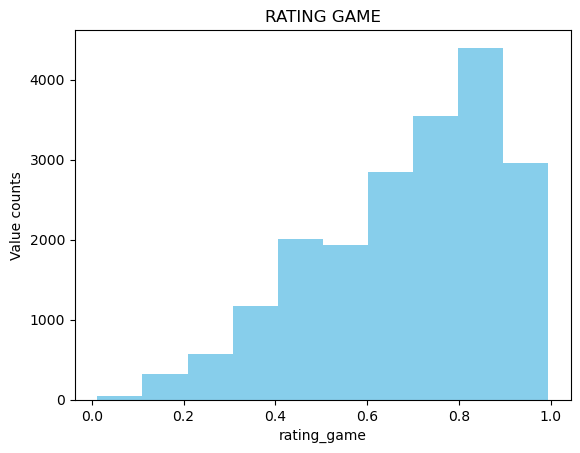

In [34]:
steam_data['rating_game'].plot(kind='hist', color='skyblue')
plt.ylabel('Value counts')
plt.xlabel('rating_game')
plt.title('RATING GAME')
plt.show()

Com abans, les dades segueixen sesgades però ara tenim una millor visualització de la columna.

In [35]:
steam_data.columns

Index(['appid', 'name', 'release_date', 'english', 'developer', 'publisher',
       'platforms', 'required_age', 'categories', 'genres', 'steamspy_tags',
       'achievements', 'positive_ratings', 'negative_ratings',
       'average_playtime', 'median_playtime', 'owners', 'price', 'rating_game',
       'num_ratings'],
      dtype='object')

El següent a fer, serà la preparació de les dades per fer els models d'aprenentatge. Haurem de fer un encoding de les dades categoriques analitzades abans i una normalització de les dades numeriques amb un escalat.

Afegim les columnes que vam analitzar al EDA

In [36]:
steam_data['is_free'] = steam_data['price'].apply(lambda x: 0 if x == 0.00 else 1)
steam_data['age_restringed'] = steam_data['required_age'].apply(lambda x: 0 if x == 0 else 1)
steam_data['game_played'] = steam_data['average_playtime'].apply(lambda x: 0 if x == 0 else 1)
steam_data['has_achievements'] = steam_data['achievements'].apply(lambda x: 0 if x == 0 else 1)

In [37]:
X = steam_data.drop(['rating_game'], axis=1)  # Usando 'rating_game' como variable objetivo
y = steam_data['rating_game']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

La codificació per aquest el faré de dues formes. Per aquelles columnes que realment són llistes (separacions amb ;) el que faré serà crear columnes separades per cadascun dels valors de les llistes sense repeticions i posar un 0 si no té aquell valor o 1 si el té. La mateixa idea que el oneHotEncoder que l'utilitzaré per la resta de variables categòriques.

In [38]:
# Codificación manual de las columnas complejas para el conjunto de entrenamiento
train_platforms = X_train['platforms'].str.split(';').apply(lambda x: pd.Series([1] * len(x), index=x)).fillna(0)
train_genres = X_train['genres'].str.split(';').apply(lambda x: pd.Series([1] * len(x), index=x)).fillna(0)
train_categories = X_train['categories'].str.split(';').apply(lambda x: pd.Series([1] * len(x), index=x)).fillna(0)

# Codificación manual de las columnas complejas para el conjunto de prueba (usando columnas del entrenamiento)
test_platforms = X_test['platforms'].str.split(';').apply(lambda x: pd.Series([1] * len(x), index=x)).fillna(0).reindex(columns=train_platforms.columns, fill_value=0)
test_genres = X_test['genres'].str.split(';').apply(lambda x: pd.Series([1] * len(x), index=x)).fillna(0).reindex(columns=train_genres.columns, fill_value=0)
test_categories = X_test['categories'].str.split(';').apply(lambda x: pd.Series([1] * len(x), index=x)).fillna(0).reindex(columns=train_categories.columns, fill_value=0)

# Codificación OneHot para atributos categóricos simples
categorical_attributes = ['game_played', 'english', 'has_achievements', 'age_restringed', 'owners', 'is_free' ]
encoder = OneHotEncoder(sparse=False)
encoder.fit(X_train[categorical_attributes])

# Transformar los conjuntos de entrenamiento y prueba
# train_categorical_encoded = encoder.transform(X_train[categorical_attributes])
train_categorical_encoded = encoder.fit_transform(X_train[categorical_attributes])
test_categorical_encoded = encoder.transform(X_test[categorical_attributes])

# Crear DataFrames para la codificación OneHot
train_categorical_encoded_df = pd.DataFrame(train_categorical_encoded, columns=encoder.get_feature_names_out(), index=X_train.index)
test_categorical_encoded_df = pd.DataFrame(test_categorical_encoded, columns=encoder.get_feature_names_out(), index=X_test.index)

# Concatenar los DataFrames codificados con el resto de los datos (menos las columnas originales no codificadas)
X_train = pd.concat([X_train.drop(categorical_attributes + ['platforms', 'genres', 'categories'], axis=1),
                               train_platforms, train_genres, train_categories,
                               train_categorical_encoded_df], axis=1)
X_test = pd.concat([X_test.drop(categorical_attributes + ['platforms', 'genres', 'categories'], axis=1),
                              test_platforms, test_genres, test_categories,
                              test_categorical_encoded_df], axis=1)


Ara realitzaré la normalització de les variables categòriques.

In [39]:
def normEscal(train, test, col):
  train[f'{col}_norm'] = np.log(train[col] + 1)
  test[f'{col}_norm'] = np.log(test[col] + 1)

  # Inicializar el escalador Min-Max
  scaler = MinMaxScaler()

  # Escalar la columna transformada 'price_norm' en el conjunto de entrenamiento y prueba
  train[f'{col}_norm'] = scaler.fit_transform(train[[f'{col}_norm']])
  test[f'{col}_norm'] = scaler.transform(test[[f'{col}_norm']])

cols = ['achievements', 'average_playtime', 'median_playtime', 'price', 'required_age', 'num_ratings']
for col in cols:
  normEscal(X_train, X_test, col)


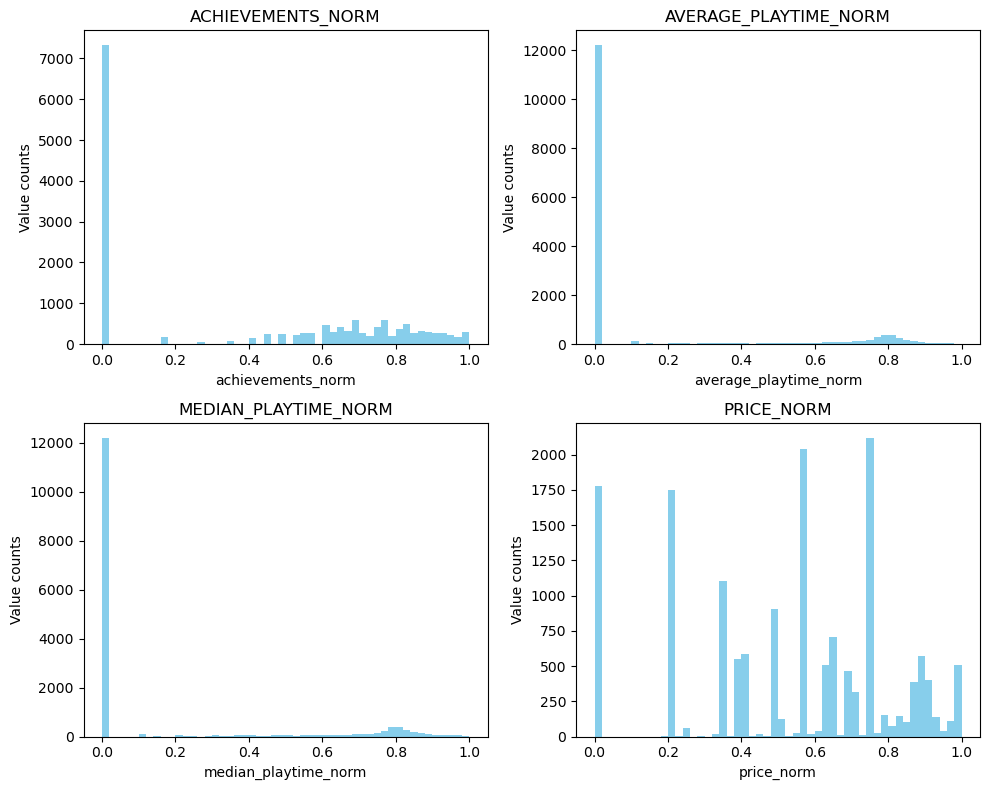

In [40]:
cols = ['achievements_norm', 'average_playtime_norm', 'median_playtime_norm', 'price_norm']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

for col, ax in zip(cols, axes.flatten()):
    X_train[col].plot(kind='hist', bins=50, ax=ax, color='skyblue')
    ax.set_ylabel('Value counts')
    ax.set_xlabel(col)
    ax.set_title(col.upper())

plt.tight_layout()
plt.show()

Els veiem una mica millor distribuits excepte pels valors que són 0 que sempre són abundants.

Fem l'eliminació de les columnes que no farem servir al nostre model, com aquelles que acabem de normalitzar i escalar.

In [41]:
# PRIMERA
# X_train_processed = X_train_processed.drop(['appid', 'name', 'release_date', 'developer', 'publisher',
#       'steamspy_tags', 'positive_ratings',
#        'negative_ratings', 'price'], axis=1)

# X_test_processed = X_test_processed.drop(['appid', 'name', 'release_date', 'developer', 'publisher',
#       'steamspy_tags', 'positive_ratings',
#        'negative_ratings', 'price'], axis=1)


X_train = X_train.drop(['appid', 'name', 'release_date', 'developer', 'publisher',
       'required_age', 'steamspy_tags', 'achievements', 'positive_ratings',
       'negative_ratings', 'average_playtime', 'median_playtime', 'price'], axis = 1)

X_test = X_test.drop(['appid', 'name', 'release_date', 'developer', 'publisher',
       'required_age', 'steamspy_tags', 'achievements', 'positive_ratings',
       'negative_ratings', 'average_playtime', 'median_playtime', 'price'], axis = 1)




Com ja hem transformat totes les dades, podem tornar a mirar les correlacions per veure si han canviat respecte abans.

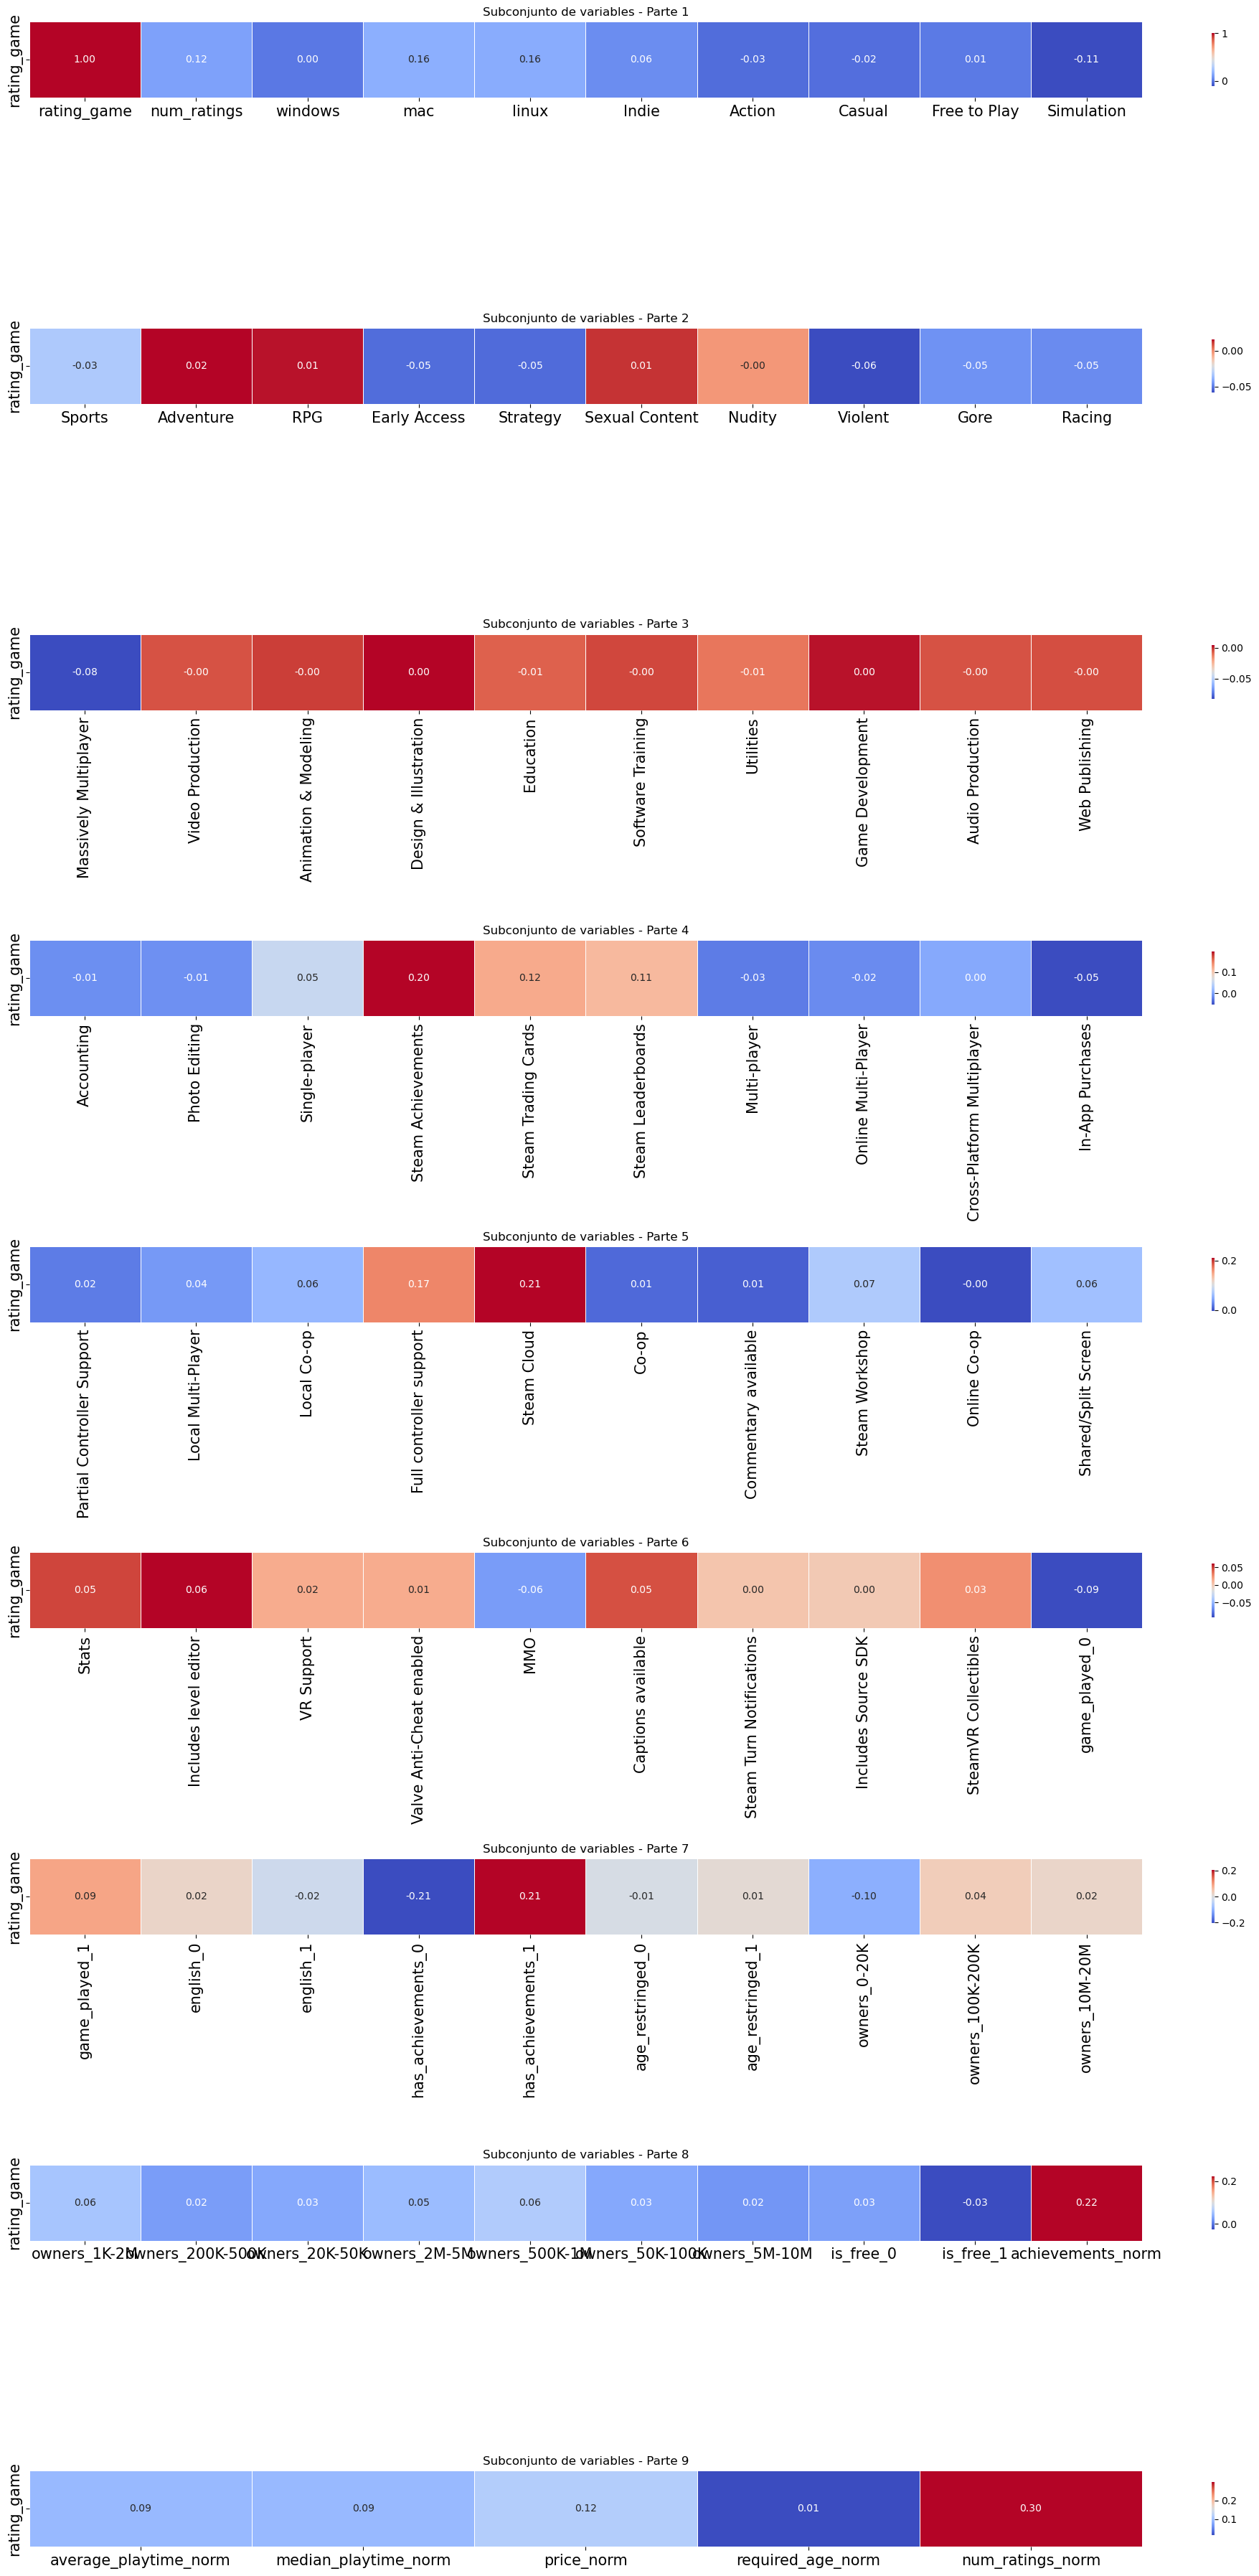

In [42]:
corr_matrix = pd.concat([y_train, X_train], axis=1).corr()

num_cols = 10
num_subplots = int(np.ceil(corr_matrix.shape[1] / num_cols))

plt.figure(figsize=(20, 4 * num_subplots))

for i in range(num_subplots):
    start_idx = i * num_cols
    end_idx = (i + 1) * num_cols
    subset_corr_matrix = corr_matrix.iloc[0, start_idx:end_idx].to_frame().T

    plt.subplot(num_subplots, 1, i + 1)
    sns.heatmap(subset_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar_kws={'shrink': 0.7})
    plt.title(f'Subconjunto de variables - Parte {i + 1}')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

plt.tight_layout()
plt.show()

No faré un analisi profund. Només em volia fixar com canvien les correlacions quant tenim les dades tractades.

Principalment veiem un increment de les correlacions a les columnes numèriques com price_norm o achievements_norm que, tot i que no és un valor alt, ens justifica que les dades dels outliers si ens eren perjudicials. També trobem increments a les correlacions de variables categoriques com has_achievements on hi ja hi havien indicis previament. Mencionar també columens com Steam_Cloud o Steam_Achievements que són columnes codificades de les nostres columnes principals genre o categories.

## Model Selection

A partir d'aqui el que faré serà probar models d'aprenentatge fent servir validació creuada. Tot i així, faré una primera observació entrenant un regressor lineal per poder veure uns primers resultats i veure si és lo esperat.

Per evaluar el meu model de regressió faré servir la mètrica R^2 (coeficient de determinació múltiple). Té una interpretació intuitiva i fàcil tenint en compte que el valor màxim serà 1 i el valor mínim serà 0. Direm que si obtenim un 0.5, el 50% de la variabilitat del nostre target s'explica pel model.

In [43]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [44]:
y_pred = model.predict(X_test)

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

r2 = r2_score(y_test, y_pred)

print(f"R^2: {r2}")

R^2: 0.21044694458826962


Podem veure que la nostra mètrica dona 0.21. No podem considerar-ho un bon resultat ja que no té en compte pràcticament tota la variabilitat de les nostres dades. Veiem quina és la gràfica scatterplot comparant les prediccions amb el test.

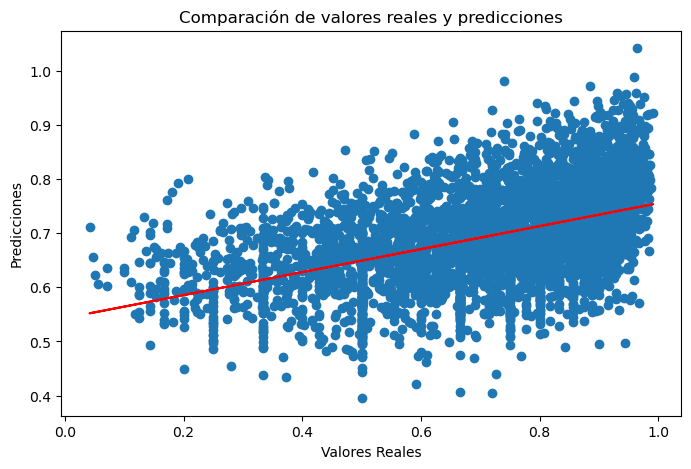

In [46]:
coef = np.polyfit(y_test, y_pred, deg=1)
poly1d_fn = np.poly1d(coef)
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred)
plt.plot(y_test, poly1d_fn(y_test), color='red')  # Línea roja es la línea de regresión
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación de valores reales y predicciones')
plt.show()

Amb la gràfica ho podem confirmar. Trobem una gran variabilitat de les dades reals i les prediccions.

Faré una taula per comparar els resultats reals i les prediccions juntament amb la diferència.

In [47]:
pred_y_df = pd.DataFrame({'Actual Value' : y_test, 'Predicted Value' : y_pred, 'Difference' : y_test - y_pred})
pred_y_df.head(5)

,Actual Value,Predicted Value,Difference
4347,0.543027,0.552321,-0.009294
22951,0.818182,0.536984,0.281198
6381,0.372881,0.686129,-0.313247
20008,0.428571,0.525907,-0.097335
12506,0.408000,0.602143,-0.194143


Podem veure bastant variabilitat. Faré dues taules més separant les dades entre les que tenen menys de 0.1 de variabilitat i les que tenen més.

In [48]:
filtered_df = pred_y_df[(pred_y_df['Difference'] > 0.1) | (pred_y_df['Difference'] < -0.1)].sort_values(by='Difference', ascending=True)
y_test_filtered = filtered_df['Actual Value'].loc[filtered_df.index].copy()
y_pred_filtered = filtered_df['Predicted Value'].loc[filtered_df.index].copy()

filtered_df.head(5)

,Actual Value,Predicted Value,Difference
25992,0.041667,0.710657,-0.668990
19806,0.047619,0.656040,-0.608421
1874,0.191226,0.793074,-0.601848
3241,0.132911,0.729922,-0.597011
3342,0.180851,0.775310,-0.594459


In [49]:
filtered_df2 = pred_y_df[(pred_y_df['Difference'] <= 0.1) & (pred_y_df['Difference'] >= -0.1)].sort_values(by='Difference', ascending=True)
y_test_filtered2 = filtered_df2['Actual Value'].loc[filtered_df2.index].copy()
y_pred_filtered2 = filtered_df2['Predicted Value'].loc[filtered_df2.index].copy()

filtered_df2.head(5)

,Actual Value,Predicted Value,Difference
14555,0.669811,0.769653,-0.099841
22885,0.726027,0.825867,-0.099840
4314,0.549296,0.648919,-0.099624
10613,0.500000,0.599016,-0.099016
3538,0.748201,0.847156,-0.098955


Veiem que com a mínim, tindrem una variabilitat de 0.1 aproximadament. I com a màxim 0.66. Aquest últim valor és un problema ja que, igual que aquest, la gran majoria tenen una gran diferencia que fa que el nostre model sigui dolent.

Tractaré d'investigar quin pot ser el fet. Per fer-ho el que faré serà analitzar com influeix el numero de ratings que té cada joc amb la diferencia de les prediccions respecte els valors reals. El que s'espera que sorti de la gràfica és que quan menys numero de rating té el joc, més diferencia trobarem. Mentre que quan més ratings tenim, la diferència disminueix.

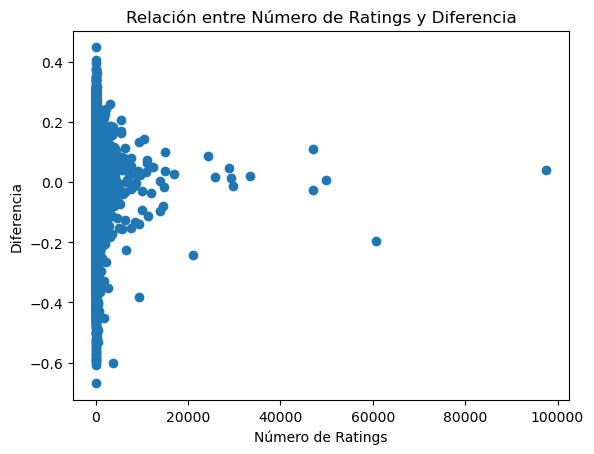

In [50]:
y_test_adapted = steam_data['num_ratings'].loc[pred_y_df.index].copy()
plt.scatter(y_test_adapted, pred_y_df['Difference'])
plt.xlabel('Número de Ratings')
plt.ylabel('Diferencia')
plt.title('Relación entre Número de Ratings y Diferencia')
plt.show()

Com s'esperava, podem veure que a mneys nombre de ratings tinguis, major serà la diferència, en general. Tot i així, continuem veient uns valors atípics que tot i tenint molts ratings, la diferencia es bastant alta. No obstant, veiem com quasi totes les dades segueixen el patró que comentavem abans.

El que faré serà una gràfica per veure com canvien els resultats segons el umbral establert. Aniré incrementant 50 en 50 i després escolliré l'umbral segons el r2 més gran.

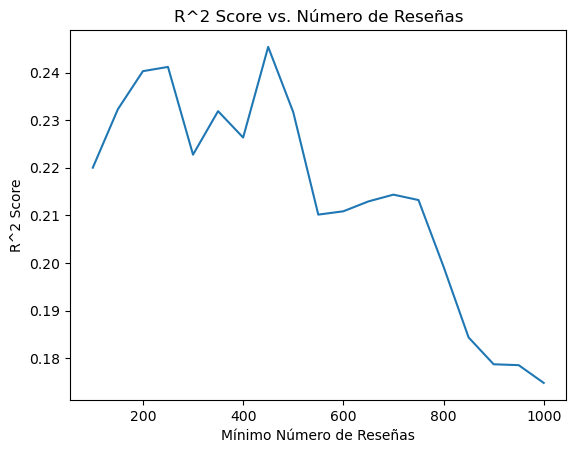

In [51]:
r2_scores = []
thresholds = range(100, 1001, 50)
threshold_r2_mapping = {}

for threshold in thresholds:
    X_train_filtered = X_train[steam_data['num_ratings'] > threshold]
    y_train_filtered = y_train[steam_data['num_ratings'] > threshold]
    X_test_filtered = X_test[steam_data['num_ratings'] > threshold]
    y_test_filtered = y_test[steam_data['num_ratings'] > threshold]

    if len(X_train_filtered) > 10:
        model = LinearRegression()
        model.fit(X_train_filtered, y_train_filtered)

        y_pred = model.predict(X_test_filtered)
        score = r2_score(y_test_filtered, y_pred)
        r2_scores.append(score)
        threshold_r2_mapping[threshold] = score
    else:
        r2_scores.append(None)

# Graficar
plt.plot(thresholds, r2_scores)
plt.xlabel('Mínimo Número de Reseñas')
plt.ylabel('R^2 Score')
plt.title('R^2 Score vs. Número de Reseñas')
plt.show()

In [52]:
best_threshold = max(threshold_r2_mapping, key=threshold_r2_mapping.get)
best_r2 = threshold_r2_mapping[best_threshold]
print(f"Millor umbral {best_threshold} amb un R^2 de {best_r2}")

Millor umbral 450 amb un R^2 de 0.2453804814736531


Com podem veure, quantes més mostres treiem pitjor són els resultats de la mètrica. El R^2 més gran que trobem correspon amb 450 d'umbral. Això vol dir que es prediu millor quan els jocs tenen en conjunt més de 450 ratings. No obstant, escollir aquest umbral ens suposa una gran perdúa de dades.

In [53]:
steam_data[steam_data['num_ratings'] > 450].shape

(2525, 24)

Tot i que no és molt més, escolliré com a umbral 250 que em permet mantenir unes quantes dades més i el resultat de la mètrica és practicament igual.

In [54]:
print(steam_data[steam_data['num_ratings'] > 250].shape)
print(f'El R^2 per un umbral de 250 és: {r2_scores[3]}')

(3782, 24)
El R^2 per un umbral de 250 és: 0.24118013485133716


In [55]:
X_train_filtered = X_train[steam_data['num_ratings'] > 250]
y_train_filtered = y_train[steam_data['num_ratings'] > 250]
X_test_filtered = X_test[steam_data['num_ratings'] > 250]
y_test_filtered = y_test[steam_data['num_ratings'] > 250]

Una vegada fet això, el que voldrem és cercar el model que apartir d'aquest umbral, millor resultats ens doni. Analitzaré els següents models de regressió:
- Regressió Lineal
- Regressió Ridge
- Regressió Random Forest
- Boosting


In [56]:
classifiers = {'LR': LinearRegression(), 'RIDGE': Ridge(), 'RF': RandomForestRegressor(), 'GBR': GradientBoostingRegressor()}
r2_scores = {'Sense hyperparametres': {'LR': 0, 'RIDGE': 0, 'RF': 0, 'GBR': 0}, 'Amb hyperparametres': {'LR': 0, 'RIDGE': 0, 'RF': 0, 'GBR': 0}}

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in classifiers.items():
    scores = cross_val_score(model, X_train_filtered, y_train_filtered, cv=kfold, scoring='r2')
    r2_scores['Sense hyperparametres'][name] = scores.mean()

param_grid = {
    'RIDGE': {
        'alpha': [0.01, 0.1, 1, 10, 100],
        'solver': ['auto', 'svd', 'cholesky']
    },
    'RF': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    },
    'GBR': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 1],
        'max_depth': [3, 4, 5],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'subsample': [0.6, 0.8, 1.0]
    }
}

results = []
best_models = {}
for name, model in classifiers.items():
    if name == 'LR':
        scores = cross_val_score(model, X_train_filtered, y_train_filtered, cv=5)
        r2_scores['Amb hyperparametres'][name] = scores.mean()
        results.append({
             'Model': name,
             'Millors Parametres': 'none',
             'Millor Scores': r2_scores['Amb hyperparametres'][name]})
    else:
        grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring='r2', n_jobs=-1)
        grid_search.fit(X_train_filtered, y_train_filtered)
        best_models[name] = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        r2_scores['Amb hyperparametres'][name] = best_score
        results.append({
            'Model': name,
            'Millors Parametres': best_params,
            'Millor Scores': best_score})

In [57]:
r2df = pd.DataFrame(r2_scores)
r2df.index.name = 'Model'
r2df.reset_index(inplace=True)
r2df

,Model,Sense hyperparametres,Amb hyperparametres
0,LR,0.250505,0.252750
1,RIDGE,0.252508,0.253438
2,RF,0.255602,0.291466
3,GBR,0.265710,0.291523


In [58]:
df = pd.DataFrame(results)
df

,Model,Millors Parametres,Millor Scores
0,LR,none,0.252750
1,RIDGE,"{'alpha': 1, 'solver': 'svd'}",0.253438
2,RF,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.291466
3,GBR,"{'learning_rate': 0.1, 'max_depth': 4, 'min_sa...",0.291523


In [59]:
results[3]['Millors Parametres']

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 100,
 'subsample': 0.8}

Podem concloure doncs, dient que el model que millor s’ajusta al nostre cas és el regressor Gradient Boosting donant uns resultats de 0.3 de R^2. Molt igualat amb el Random Forest, pel que podem escollir qualsevol dels dos. La cerca d’hiperparàmetres ha resultat útil.

Per últim, fem una avaluació final amb el test i així obtenir els resultats finals.


In [60]:
gbr = GradientBoostingRegressor(**results[3]['Millors Parametres'])
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

In [61]:
r2 = r2_score(y_test, y_pred)

print(f"R^2: {r2}")

R^2: 0.2315976513074839


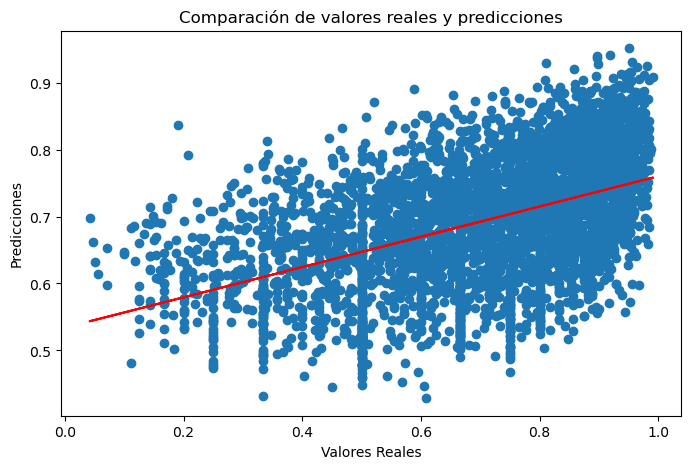

In [62]:
coef = np.polyfit(y_test, y_pred, deg=1)
poly1d_fn = np.poly1d(coef)
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred)
plt.plot(y_test, poly1d_fn(y_test), color='red')  # Línea roja es la línea de regresión
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación de valores reales y predicciones')
plt.show()

Com s'esperava, els resultats no canvien cap a bé i, fins i tot empitjora una mica.

Per finalitzar aquest projecte, parlaré de les conclusions que he extret d'aquest projecte. 

Podem concloure diversos aspectes dels resultats obtinguts. El primer, i més important, és veure que amb les dades aportades difícilment trobarem relacions amb el que es volia predir, per no dir impossible. Sí que trobàvem petites relacions que anaven lligades al “target” però no era suficientment forta com per dictaminar completament la predicció final. Altre conclusió important a la qual he arribat al final del projecte ha sigut que trobem una forta relació en com influeix el número de “ratings” en una predicció final, ja que, quants menys tinguem, pitjor serà la predicció. Finalment dir que el “dataset” utilitzat podria haver-se orientat d’altra forma aconseguint així uns resultats molt diferents. No obstant, es casi segur que de la forma en la que lo he orientat jo, és molt probable que els resultats siguin els mateixos. Al ser un dataset on les dades ja estan molt marcades i és difícil fer un Feature Engineering, els resultats no canviarien molt.